#  <font color='#FFE15D'><b>💎 Image Captioning 🐬</b></font>



# 🔴 **Environment Setup**

In [ ]:
!pip install -q torch==2.3.0 torchtext==0.18.0 torchvision==0.18 torchmetrics portalocker>=2.0.0

In [ ]:
!pip install -q wandb torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


# 🔴 **Import Libs**

In [ ]:
import os
import random
from collections import defaultdict
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import wandb

from PIL import Image

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchvision
from torchvision.datasets import VisionDataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence

from torch import optim
from torch.nn import functional as F

# from torcheval.metrics import BLEUScore

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.3.0+cu121
torchtext --> 0.18.0+cpu
torchvision --> 0.18.0+cu121
tqdm --> 4.66.5


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔴 **Arguments**

In [ ]:
seed = 8

batch_size = 128

embed_size = 300
hidden_size = 500
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.5
max_seq_length = 20

clip = 0.25

lr = 1.25
momentum = 0.9
wd = 1e-4
metric = None

wandb = False

In [ ]:
if wandb:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# 🔴 **Dataset**

## 🟠 Load the Dataset

In [ ]:
!mkdir flickr8k
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -P flickr8k/
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -P flickr8k/

In [ ]:
!unzip -q flickr8k/Flickr8k_Dataset.zip -d flickr8k/
!unzip -q flickr8k/Flickr8k_text.zip -d flickr8k/

In [ ]:
!rm flickr8k/Flickr8k_Dataset.zip
!rm flickr8k/Flickr8k_text.zip

In [ ]:
!ls flickr8k/

CrowdFlowerAnnotations.txt  Flickr_8k.devImages.txt   Flickr8k.token.txt	 readme.txt
ExpertAnnotations.txt	    Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
Flicker8k_Dataset	    Flickr_8k.testImages.txt  __MACOSX


In [ ]:
! cp /content/drive/MyDrive/Deep_learning_projects/2_Image_captioning/model.pt /content/

In [ ]:
! cp /content/vocab.pt /content/drive/MyDrive/Deep_learning_projects/2_Image_captioning/

## 🟠 EDA

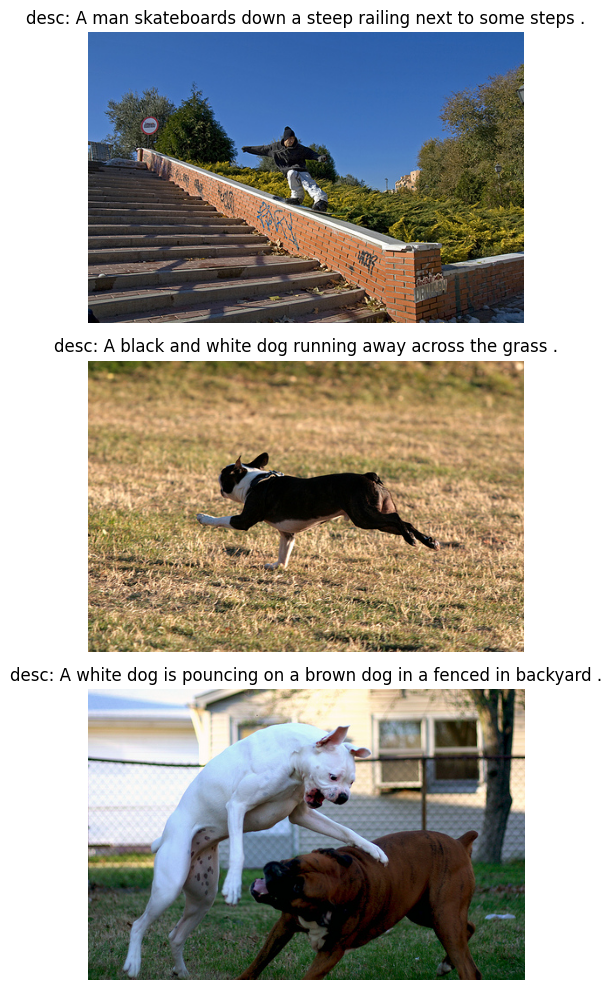

In [ ]:
dataset_folder = '/content/flickr8k/Flicker8k_Dataset'
captions_dir = '/content/flickr8k/Flickr8k.token.txt'

def show_random_samples(num_samples=3):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    captions_dict = {}
    with open(captions_dir) as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) > 1:
                image_filename = parts[0].split('#')[0]
                caption = parts[1]
                if image_filename in captions_dict:
                    captions_dict[image_filename].append(caption)
                else:
                    captions_dict[image_filename] = [caption]

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)

        image = Image.open(image_path)

        captions = captions_dict.get(image_file, ["No caption available"])
        caption_to_display = random.choice(captions)

        plt.subplot(num_samples, 1, idx)
        plt.imshow(image)
        plt.title(f"desc: {caption_to_display}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

In [ ]:
captions_file = '/content/flickr8k/Flickr8k.token.txt'

file_names = []
caption_ids = []
captions = []

with open(captions_file, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            file_id = parts[0]
            caption = parts[1]

            filename, cap_id = file_id.split('#')

            file_names.append(filename)
            caption_ids.append(cap_id)
            captions.append(caption)

df = pd.DataFrame({
    'File Name': file_names,
    'Caption ID': caption_ids,
    'Caption': captions
})

df.to_csv('flickr8k_captions.csv', index=False)

In [ ]:
df

,File Name,Caption ID,Caption
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,A man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,1,A man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg,2,A person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,3,A rock climber in a red shirt .


In [ ]:
grouped_df = df.groupby('File Name').agg(list)
grouped_df.head()

,Caption ID,Caption
File Name,,
1000268201_693b08cb0e.jpg,"[0, 1, 2, 3, 4]",[A child in a pink dress is climbing up a set ...
1001773457_577c3a7d70.jpg,"[0, 1, 2, 3, 4]","[A black dog and a spotted dog are fighting, A..."
1002674143_1b742ab4b8.jpg,"[0, 1, 2, 3, 4]",[A little girl covered in paint sits in front ...
1003163366_44323f5815.jpg,"[0, 1, 2, 3, 4]",[A man lays on a bench while his dog sits by h...
1007129816_e794419615.jpg,"[0, 1, 2, 3, 4]",[A man in an orange hat starring at something ...


In [ ]:
for file_name, row in grouped_df.sample(5).iterrows():
    print(f"File: {file_name}")
    for cap_id, caption in zip(row['Caption ID'], row['Caption']):
        print(f"  Caption {cap_id}: {caption}")
    print()


File: 463978865_c87c6ca84c.jpg
  Caption 0: A man sitting on the left near a man walking along the side of a street with colorful buildings .
  Caption 1: A man walking by a sitting man on the street .
  Caption 2: A man with dreadlocks and a backpack walks down the sidewalk with colorful buildings in the background .
  Caption 3: A white man with dreadlocks walks down the sidewalk .
  Caption 4: Two boys are on the sidewalk as cars pass by on the road .

File: 506808265_fe84ada926.jpg
  Caption 0: A lady with red hair is standing in front of a mixing table with another person behind her holding up their hands .
  Caption 1: A middle aged woman is standing by a DJ deck in a house .
  Caption 2: A middle aged woman pretends to be a DJ as younger people point .
  Caption 3: An older woman stands by turn tables as another female flips off the camera .
  Caption 4: Red haired lady acts like a DJ .

File: 3364715316_df8c20bac1.jpg
  Caption 0: Two people play on the beach .
  Caption 1: Two

## 🟠 Custom dataset

In [ ]:
class Flickr8k(VisionDataset):
    """
    Args:
        root (string): Root directory where images are downloaded to.
        ann_file (string): Path to annotation file.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(
        self,
        root: str,
        ann_file: str,
        split_file: str,
        train: bool,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.ann_file = os.path.expanduser(ann_file)
        self.train = train

        # Read {train/dev/test} files
        with open(split_file) as f:
            self.split_samples = f.read().strip().split("\n")

        # Read annotations and store in a dict
        self.ids, self.captions = [], []
        with open(self.ann_file) as fh:
            for line in fh:
                img_id, caption = line.strip().split("\t")
                if img_id[:-2] in self.split_samples:
                    self.ids.append(img_id[:-2])
                    self.captions.append(caption)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is a list of captions for the image.
        """
        img_id = self.ids[index]

        # Image
        filename = os.path.join(self.root, img_id)
        img_raw = Image.open(filename).convert("RGB")
        if self.transform is not None:
            img = self.transform(img_raw)

        # Captions
        caption = self.captions[index]
        if self.target_transform is not None:
            target = self.target_transform(caption)

        if self.train:
            return img, target
        else:
          return img, img_raw, caption

    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
class CaptionTransform:

    def __init__(self, caption_file):
        captions = self._load_captions(caption_file)

        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = build_vocab_from_iterator(map(self.tokenizer, captions),
                                               specials=['<pad>', '<unk>', '<sos>', '<eos>'])
        self.vocab.set_default_index(self.vocab['<unk>'])

        torch.save(self.vocab, 'vocab.pt')

    def __call__(self, caption):
        indices = self.vocab(self.tokenizer(caption))
        indices = self.vocab(['<sos>']) + indices + self.vocab(['<eos>'])
        target = torch.LongTensor(indices)
        return target

    def __repr__(self):
        return f"""CaptionTransform([
          _load_captions(),
          toknizer('basic_english'),
          vocab(vocab_size={len(self.vocab)})
          ])
          """

    def _load_captions(self, caption_file):
        captions = []
        with open(caption_file) as f:
            for line in f:
                _, caption = line.strip().split("\t")
                captions.append(caption)
        return captions

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

root = '/content/flickr8k/Flicker8k_Dataset'
ann_file = '/content/flickr8k/Flickr8k.token.txt'
split_file = lambda phase: f'/content/flickr8k/Flickr_8k.{phase}Images.txt'

caption_transform = CaptionTransform(ann_file)

train_set = Flickr8k(root, ann_file, split_file('train'), True, train_transform, caption_transform)
valid_set = Flickr8k(root, ann_file, split_file('dev'), True, eval_transform, caption_transform)
test_set = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)

len(train_set), len(valid_set), len(test_set)

(30000, 5000, 5000)

In [ ]:
train_set[1][0]

tensor([[[ 0.0912,  0.0398,  0.0056,  ...,  1.6495, -0.3027, -1.2103],
         [ 0.1083,  0.0398, -0.0116,  ...,  1.1529, -0.7822, -1.4158],
         [ 0.0912,  0.0569,  0.0056,  ..., -0.8164, -1.6384, -1.8268],
         ...,
         [ 1.4612,  1.6838,  1.9235,  ..., -0.7650, -0.7650, -0.7822],
         [ 1.9235,  2.1290,  2.1804,  ..., -0.8849, -0.8849, -0.8507],
         [ 2.0092,  2.0777,  2.0777,  ..., -0.4054, -0.6281, -0.7650]],

        [[ 0.4678,  0.4153,  0.3627,  ...,  1.2031, -0.8627, -1.3004],
         [ 0.4503,  0.3978,  0.3277,  ...,  0.9230, -0.9678, -1.2829],
         [ 0.4503,  0.3978,  0.3452,  ..., -0.9678, -1.3880, -1.5280],
         ...,
         [ 0.8354,  1.0280,  1.2381,  ...,  0.1702,  0.1527,  0.1352],
         [ 1.3256,  1.5007,  1.5882,  ...,  0.0476,  0.0476,  0.1176],
         [ 1.2731,  1.3431,  1.4832,  ...,  0.2227,  0.1702,  0.1702]],

        [[ 0.3393,  0.2871,  0.2348,  ...,  1.5594, -0.7238, -1.4733],
         [ 0.3742,  0.3219,  0.2522,  ...,  0

## 🟠 Define a dataloader

In [ ]:
def collate_fn(batch):
  if len(batch[0]) == 2:
      x_batch, y_batch = zip(*batch)
      x_batch = torch.stack(x_batch)
      y_batch = pad_sequence(y_batch, batch_first=True, padding_value=caption_transform.vocab['<pad>'])
      return x_batch, y_batch
  else:
    x_batch, x_raw, captions = zip(*batch)
    x_batch = torch.stack(x_batch)
    return x_batch, x_raw, captions

In [ ]:
train_loader = DataLoader(train_set, batch_size=20, shuffle=True, collate_fn= collate_fn)
test_loader = DataLoader(test_set, batch_size=20, shuffle=True, collate_fn= collate_fn)
valid_loader = DataLoader(valid_set, batch_size=20, shuffle=True, collate_fn= collate_fn)

In [ ]:
next(iter(train_loader))

(tensor([[[[-1.4843, -1.5870, -1.7925,  ..., -1.7925, -1.8097, -1.7925],
           [-1.3644, -1.4843, -1.5870,  ..., -1.9295, -1.8782, -1.8782],
           [-1.2959, -1.6384, -1.5870,  ..., -1.9467, -1.8610, -1.8097],
           ...,
           [-1.7240, -1.6727, -1.3130,  ..., -1.8439, -1.8953, -1.9638],
           [-1.8782, -1.8097, -1.4672,  ..., -1.8097, -1.7925, -1.8268],
           [-1.7925, -1.8439, -1.3130,  ..., -1.7240, -1.5357, -1.6384]],
 
          [[-1.3880, -1.5105, -1.6681,  ..., -1.7206, -1.7381, -1.7031],
           [-1.2829, -1.4230, -1.4930,  ..., -1.8431, -1.7731, -1.7731],
           [-1.1779, -1.5630, -1.4930,  ..., -1.8606, -1.7906, -1.7381],
           ...,
           [-1.6681, -1.6506, -1.3529,  ..., -1.7906, -1.8431, -1.8782],
           [-1.8081, -1.7556, -1.4405,  ..., -1.8081, -1.7906, -1.8081],
           [-1.7381, -1.7556, -1.2654,  ..., -1.7381, -1.6155, -1.6681]],
 
          [[-1.3687, -1.3861, -1.4733,  ..., -1.6127, -1.5953, -1.5953],
           [-

# 🔴 **Model**

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()

    self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    self.resnet.requires_grad_(False)
    feature_size = self.resnet.fc.in_features

    self.resnet.fc = nn.Identity()

    self.linear = nn.Linear(feature_size, embed_size)
    self.bn = nn.BatchNorm1d(embed_size)

  def forward(self, images):
    self.resnet.eval()
    with torch.no_grad():
      features = self.resnet(images)
    features = self.bn(self.linear(features))
    return features

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout_embd, dropout_rnn, max_seq_length=20):
    super(DecoderRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=caption_transform.vocab['<pad>'])
    self.dropout_embd = nn.Dropout(dropout_embd)

    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rnn, batch_first=True)

    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

    self.init_weights()

  def init_weights(self):
      self.embedding.weight.data.uniform_(-0.1, 0.1)
      self.linear.bias.data.fill_(0)
      self.linear.weight.data.uniform_(-0.1, 0.1)

  def forward(self, features, captions):
    embeddings = self.dropout_embd(self.embedding(captions[:, :-1]))
    inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    outputs, _ = self.lstm(inputs)
    outputs = self.linear(outputs)
    return outputs

  def generate(self, features, captions):
    if len(captions) > 0:
        embeddings = self.dropout_embd(self.embedding(captions))
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    else:
        inputs = features.unsqueeze(1)

    outputs, _ = self.lstm(inputs)
    outputs = self.linear(outputs)
    return outputs

In [ ]:
class ImageCaptioning(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,
               dropout_embd, dropout_rnn, max_seq_length=20):
    super(ImageCaptioning, self).__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers,
                              dropout_embd, dropout_rnn, max_seq_length)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

  def generate(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder.generate(features, captions)
    return outputs

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=caption_transform.vocab['<pad>'])

metric = None

In [ ]:
key_file = '/content/key'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

Key file does not exist. Please create the key file with your wandb API key.


# 🔴 **Train ➰**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  if metric: metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      if metric:
        metric.update(outputs, targets)
        metric_train_val = metric.compute().item()
      else:
        metric_train_val = None

      tepoch.set_postfix(loss=loss_train.avg, metric=metric_train_val)

    return model, loss_train.avg, metric_train_val

# 🔴 **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  if metric: metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      if metric: metric(outputs, targets)

  return loss_eval.avg, metric.compute().item() if metric else None

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs, targets)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(9.0927, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn=collate_fn)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric,epoch)

Epoch 99: 100%|██████████| 50/50 [00:09<00:00,  5.32batch/s, loss=0.0323, metric=None]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 1

for lr in [0.9, 0.5, 0.125, 0.005]:
  print(f'LR={lr}')

  model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                          dropout_embd, dropout_rnn, max_seq_length).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

  print()

LR=0.9


Epoch 1: 100%|██████████| 1500/1500 [04:58<00:00,  5.03batch/s, loss=3.49, metric=None]



LR=0.5


Epoch 1: 100%|██████████| 1500/1500 [04:52<00:00,  5.13batch/s, loss=3.58, metric=None]



LR=0.125


Epoch 1: 100%|██████████| 1500/1500 [04:52<00:00,  5.13batch/s, loss=4.03, metric=None]



LR=0.005


Epoch 1: 100%|██████████| 1500/1500 [04:59<00:00,  5.00batch/s, loss=5.9, metric=None]

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 2

for lr in [1.25]:
  for wd in [1e-4, 1e-5, 1e-6, 0]:
    print(f'LR={lr}, WD={wd}')

    model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                            dropout_embd, dropout_rnn, max_seq_length).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

    print()

LR=1.25, WD=0.0001


Epoch 2: 100%|██████████| 1500/1500 [04:51<00:00,  5.15batch/s, loss=3.04, metric=None]



LR=1.25, WD=1e-05


Epoch 2: 100%|██████████| 1500/1500 [05:00<00:00,  4.99batch/s, loss=2.87, metric=None]



LR=1.25, WD=1e-06


Epoch 2: 100%|██████████| 1500/1500 [05:01<00:00,  4.98batch/s, loss=2.86, metric=None]



LR=1.25, WD=0


Epoch 1:   0%|          | 4/1500 [00:00<04:57,  5.02batch/s, loss=8.89, metric=None]

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(seed)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [ ]:
set_seed(seed)
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [ ]:
model = torch.load('model.pt')

In [ ]:
set_seed(seed)
lr = 0.125
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project='image-captioning',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = None')
  print()

  if wandb:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 235/235 [04:41<00:00,  1.20s/batch, loss=2.52, metric=None]


Model Saved!
Valid: Loss = 2.787, Metric = None



Epoch 2: 100%|██████████| 235/235 [04:42<00:00,  1.20s/batch, loss=2.52, metric=None]


Model Saved!
Valid: Loss = 2.787, Metric = None



Epoch 3: 100%|██████████| 235/235 [04:44<00:00,  1.21s/batch, loss=2.52, metric=None]


Valid: Loss = 2.788, Metric = None



Epoch 4: 100%|██████████| 235/235 [04:43<00:00,  1.21s/batch, loss=2.51, metric=None]


Valid: Loss = 2.787, Metric = None



Epoch 5: 100%|██████████| 235/235 [04:43<00:00,  1.21s/batch, loss=2.51, metric=None]


Valid: Loss = 2.789, Metric = None



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/model.pt /content/drive/MyDrive/Deep_learning_projects/2_Image_captioning

In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

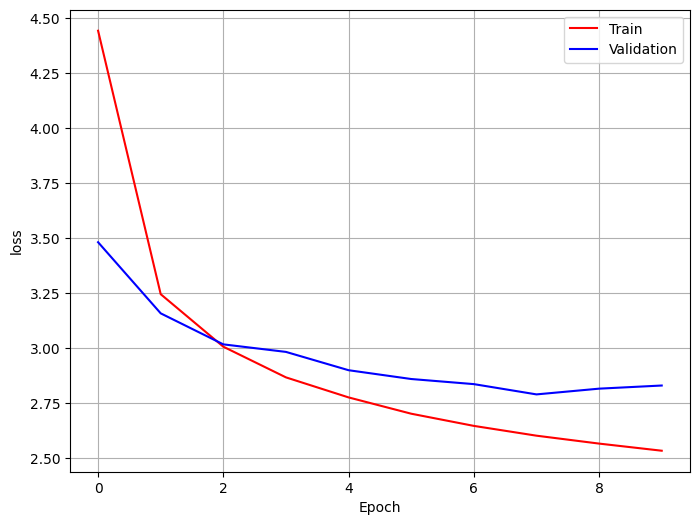

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Caption**

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

ImageCaptioning(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [ ]:
def generate(image, model, vocab, max_seq_len, device):
  image = image.to(device)
  src, indices = [], []

  caption = ''
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    with torch.no_grad():
      predictions = model.generate(image, src)

    idx = predictions[:, -1, :].argmax(1)
    token = itos[idx]

    caption += token + ' '
    if idx == vocab['<eos>']:
      break

    indices.append(idx)
    src = torch.LongTensor([indices]).to(device)

  return caption.replace('<sos> ', '').replace(' <eos>', '').capitalize()

In [ ]:
test_set_generate = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)

Target:  A martial artist breaks ice with a kick .
Model: A man is sliding down a ramp . 


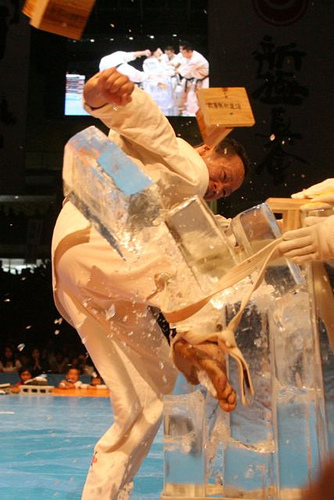

In [ ]:
idx = torch.randint(0, len(test_set_generate), (1,)).item()
image, image_raw, target = test_set_generate[idx]

caption = generate(image.unsqueeze(0), model, caption_transform.vocab, 20, device)

print('Target: ', target)
print('Model:', caption)
image_raw

# 🔴 **Test**

In [ ]:
def calculate_bleu(model, dataloader, tokenizer, vocab, n_gram, device, max_seq_len=20):
    bleu = BLEUScore(n_gram=n_gram)
    for images, _, captions in dataloader:
        images = images.to(device)

        generated_caption = generate(images[[0], ...], model, vocab, max_seq_len, device)

        candidates = [generated_caption]
        references = [captions]

        bleu.update(candidates, references)

    return bleu.compute()

In [ ]:
test_set_generate = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)
test_loader = DataLoader(test_set_generate, batch_size=5, collate_fn=collate_fn)

In [ ]:
_, _, captions = next(iter(test_loader))
captions

('A blond woman in a blue shirt appears to wait for a ride .',
 'A blond woman is on the street hailing a taxi .',
 'A woman is signaling is to traffic , as seen from behind .',
 'A woman with blonde hair wearing a blue tube top is waving on the side of the street .',
 'The woman in the blue dress is holding out her arm at oncoming traffic .')

In [ ]:
bleu_1 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 1, device)
bleu_2 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 2, device)
bleu_3 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 3, device)
bleu_4 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 4, device)

In [ ]:
print(f'BLEU 1: {bleu_1}\nBLEU 2: {bleu_2}\nBLEU 3: {bleu_3}\nBLEU 4: {bleu_4}')

BLEU 1: 0.6107600649936812
BLEU 2: 0.3907169238694986
BLEU 3: 0.25185617682512557
BLEU 4: 0.16357451778347545
